<a href="https://colab.research.google.com/github/valerio-unifei/ECO904/blob/main/ECO904_2024_1_Atividade_2_Etapa_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 2 - Etapa 3

[Proposta](https://docs.google.com/document/d/e/2PACX-1vTvlDZCbl8BtQfBQ3a0CPt_KDnxzQx_8E18iJMJxZ5R05cgX18hx0R8iwd5g3didFwDUHpJRRkqqQqs/pub)

Utilizar uma rede ViT:
- Escolher o modelo de rede
- Realizar ajuste fino de aprendizado
- Verificar resultados e tempo de aprendizagem

## Instalando pacotes do HuggingFace

In [ ]:
!pip install -q datasets transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 20.1 MB/s eta 0:00:00


In [ ]:
import transformers
print('Transformes:',transformers.__version__)
import datasets
print('Datasets:',datasets.__version__)

Transformes: 4.40.2
Datasets: 2.19.1


## Base de Dados

In [ ]:
import os
from google.colab import files, userdata

if not os.path.exists('/content/data'):
  if not os.path.exists('kaggle.json'):
    try:
      kaggle_key = userdata.get('kaggle_key')
      open('kaggle.json','w').write(kaggle_key)
    except:
      files.upload()

  !pip install -q kaggle

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !rm kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download 'smaranjitghose/corn-or-maize-leaf-disease-dataset'
  !unzip -qq corn-or-maize-leaf-disease-dataset.zip
  !rm corn-or-maize-leaf-disease-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 99% 159M/161M [00:08<00:00, 20.4MB/s]
100% 161M/161M [00:08<00:00, 20.6MB/s]


In [ ]:
from datasets import load_dataset
splits = load_dataset('data')['train'].train_test_split(test_size=0.2)
train_ds = splits['train']
val_ds = splits['test']

Resolving data files:   0%|          | 0/4188 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'], id=None)}

In [ ]:
val_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'], id=None)}

Label: 1


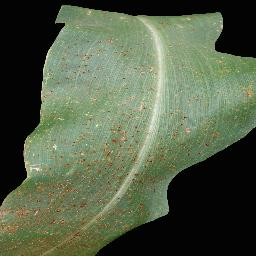

In [ ]:
print('Label:',train_ds[10]['label'])
train_ds[10]['image']

## Redes ViT

[Referência](https://huggingface.co/blog/fine-tune-vit)

Assim como os modelos baseados em transformadores revolucionaram a PNL, estamos vendo agora uma explosão de artigos que os aplicam a todos os tipos de outros domínios. Um dos mais revolucionários foi o Vision Transformer (ViT), lançado em junho de 2021 por uma equipe de pesquisadores do Google Brain.

Este artigo explorou como você pode tokenizar imagens, da mesma forma que tokenizaria frases, para que elas possam ser passadas para modelos de transformadores para treinamento. É um conceito bastante simples, na verdade:
- Dividir uma imagem em uma grade de patches de subimagem
- Incorpore cada patch com uma projeção linear
- Cada patch incorporado torna-se um token, e a sequência resultante de patches incorporados é a sequência que você passa para o modelo.

<img src="https://huggingface.co/blog/assets/51_fine_tune_vit/vit-figure.jpg">

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Pre-procesando os Dados

In [ ]:
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from torchvision.transforms import (CenterCrop, Compose, Normalize,
                                    RandomHorizontalFlip, RandomResizedCrop,
                                    Resize, ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

In [ ]:
print(train_ds[1])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7C6F929CB2B0>, 'label': 1, 'pixel_values': tensor([[[ 0.1608,  0.1843,  0.2314,  ..., -0.1373, -0.2392, -0.2784],
         [ 0.1529,  0.1765,  0.2235,  ..., -0.1294, -0.2157, -0.2549],
         [ 0.1373,  0.1529,  0.1843,  ..., -0.0902, -0.1059, -0.1137],
         ...,
         [ 0.1608,  0.1529,  0.1294,  ...,  0.1608,  0.2314,  0.2549],
         [ 0.1686,  0.1608,  0.1294,  ...,  0.1765,  0.2471,  0.2784],
         [ 0.1686,  0.1608,  0.1294,  ...,  0.1765,  0.2471,  0.2784]],

        [[ 0.2000,  0.2235,  0.2784,  ...,  0.0745, -0.0275, -0.0667],
         [ 0.1922,  0.2157,  0.2627,  ...,  0.0824, -0.0039, -0.0431],
         [ 0.1529,  0.1686,  0.2000,  ...,  0.1216,  0.1059,  0.0980],
         ...,
         [ 0.2863,  0.2784,  0.2627,  ...,  0.2078,  0.2627,  0.2941],
         [ 0.2941,  0.2863,  0.2706,  ...,  0.2078,  0.2784,  0.3098],
         [ 0.2941,  0.2863,  0.2706,  ...,  0.2078,  0.2784,  0.3098

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


## Definindo o Modelo

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Blight', 1: 'Common_Rust', 2: 'Gray_Leaf_Spot', 3: 'Healthy'}

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-data",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [ ]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

## Treinando o Modelo

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.180874,0.960621
2,0.364900,0.139956,0.966587
3,0.169400,0.129376,0.968974


TrainOutput(global_step=1005, training_loss=0.2663548990268612, metrics={'train_runtime': 465.2423, 'train_samples_per_second': 21.602, 'train_steps_per_second': 2.16, 'total_flos': 7.788084558041088e+17, 'train_loss': 0.2663548990268612, 'epoch': 3.0})

## Avaliando o Ajuste Fino

In [ ]:
outputs = trainer.predict(val_ds)

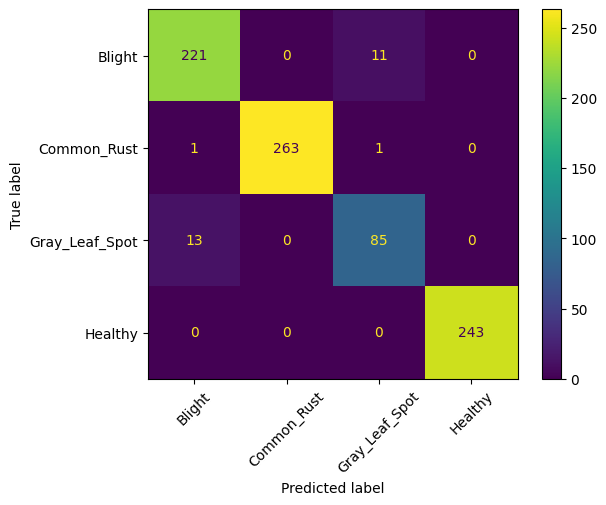

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)